## Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

## Load Dataset

In [16]:
data = pd.read_excel("Updated_NWMP_DATA_2022_with_WQI.xlsx")

## Compute averages with robust error handling

In [17]:
def robust_column_search(columns, base_name, suffixes=['Min', 'Max']):
    found = {}
    base_name_clean = base_name.replace(' ', '').replace('+', '').replace('-', '').replace('(', '').replace(')', '').lower()
    for suffix in suffixes:
        for col in columns:
            col_clean = col.replace(' ', '').replace('+', '').replace('-', '').replace('(', '').replace(')', '').lower()
            if base_name_clean in col_clean and suffix.lower() in col_clean:
                found[suffix] = col
                break
        else:
            found[suffix] = None
    return found

avg_specs = [
    ('Temperature (oC)', 'Temperature (oC) Avg'),
    ('pH', 'pH Avg'),
    ('Conductivity (µmhos/cm)', 'Conductivity (µmhos/cm) Avg'),
    ('BOD (mg/L)', 'BOD (mg/L) Avg'),
    ('Nitrate-N + Nitrite-N (mg/L)', 'Nitrate Avg'),
    ('Arsenic (mg/L)', 'Arsenic Avg'),
    ('Fluoride (mg/L)', 'Fluoride Avg'),
    ('Fecal Coliform (MPN/100ml)', 'Faecal Coliform Avg'),
    ('Total Coliform (MPN/100ml)', 'Total Coliform Avg'),
    ('Total Dissolved Solids (mg/L)', 'Total Dissolved Solids Avg')
]

for base, avg_col in avg_specs:
    cols = robust_column_search(data.columns, base)
    if cols['Min'] and cols['Max']:
        data[avg_col] = data[[cols['Min'], cols['Max']]].mean(axis=1)
    else:
        data[avg_col] = np.nan  # or handle as needed

## Updated standards (WHO/BIS compliant)

In [18]:
standards = {
    'BOD (mg/L) Avg': 5.0,        # BIS standard
    'pH Avg': (6.5, 8.5),          # Range instead of single value
    'Conductivity (µmhos/cm) Avg': 2500,  # Drinking water limit
    'Nitrate Avg': 45,              # BIS standard
    'Faecal Coliform Avg': 1,       # Not detectable standard
    'Total Coliform Avg': 1,
    'Total Dissolved Solids Avg': 500,  # BIS standard
    'Fluoride Avg': 1.5,            # WHO standard
    'Arsenic Avg': 0.01             # Unchanged
}

ideal_values = {
    'BOD (mg/L) Avg': 0,
    'pH Avg': 7,
    'Conductivity (µmhos/cm) Avg': 0,
    'Nitrate Avg': 0,
    'Faecal Coliform Avg': 0,
    'Total Coliform Avg': 0,
    'Total Dissolved Solids Avg': 0,
    'Fluoride Avg': 0,
    'Arsenic Avg': 0
}

# 6. Balanced weights
weights = {
    'pH Avg': 0.15,
    'Total Dissolved Solids Avg': 0.15,
    'Conductivity (µmhos/cm) Avg': 0.12,
    'Nitrate Avg': 0.12,
    'Fluoride Avg': 0.12,
    'Arsenic Avg': 0.12,
    'BOD (mg/L) Avg': 0.08,
    'Faecal Coliform Avg': 0.07,
    'Total Coliform Avg': 0.07
}

## Enhanced WQI calculation

In [19]:
def calculate_qn(value, param):
    if param == 'pH Avg':
        lower, upper = standards[param]
        if value < 7:
            return max(0, (7 - value) / (7 - lower) * 50)
        else:
            return max(0, (value - 7) / (upper - 7) * 50)
    else:
        Vn = value
        Videal = ideal_values[param]
        Sn = standards[param]
        return 100 * (Vn - Videal) / (Sn - Videal)

def calculate_wqi(row):
    score = 0
    for param in weights:
        if param in row and not pd.isna(row[param]):
            score += calculate_qn(row[param], param) * weights[param]
    return score

data['WQI'] = data.apply(calculate_wqi, axis=1)
def quality_status(wqi):
    if wqi <= 25: return "Excellent"
    elif wqi <= 50: return "Good"
    elif wqi <= 75: return "Poor"
    elif wqi <= 100: return "Very Poor"
    else: return "Unfit for Consumption"
data['Quality Status'] = data['WQI'].apply(quality_status)

## Select features and targets

In [20]:
features = [
    'Temperature (oC) Avg', 'pH Avg', 'Conductivity (µmhos/cm) Avg',
    'BOD (mg/L) Avg', 'Faecal Coliform Avg', 'Total Coliform Avg', 'Total Dissolved Solids Avg'
]
X = data[features]
y_fluoride = data['Fluoride Avg']
y_arsenic = data['Arsenic Avg']
y_nitrate = data['Nitrate Avg']

## Split data with consistent indexing

In [21]:
X_train, X_test, y_train_fluoride, y_test_fluoride = train_test_split(X, y_fluoride, test_size=0.33, random_state=42)
_, _, y_train_arsenic, y_test_arsenic = train_test_split(X, y_arsenic, test_size=0.33, random_state=42)
_, _, y_train_nitrate, y_test_nitrate = train_test_split(X, y_nitrate, test_size=0.33, random_state=42)

## Model training with cross-validation

In [22]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

## Evaluate models with cross-validation

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    # Test evaluation
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)

    return {
        'model': model,
        'cv_rmse': cv_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'feature_importances': getattr(model, 'feature_importances_', None)
    }


## Evaluate all models for each target

In [30]:
results = {}
for target_name, (y_train, y_test) in zip(
    ['Fluoride', 'Arsenic', 'Nitrate'],
    [(y_train_fluoride, y_test_fluoride),
     (y_train_arsenic, y_test_arsenic),
     (y_train_nitrate, y_test_nitrate)]
):
    target_results = {}
    for model_name, model in models.items():
        target_results[model_name] = evaluate_model(
            model, X_train, y_train, X_test, y_test
        )
    results[target_name] = target_results


## Print performance metrics

In [31]:
print("Model Performance Metrics:")
for target_name in results:
    print(f"\n--- {target_name} ---")
    for model_name, metrics in results[target_name].items():
        print(f"{model_name}:")
        print(f"  CV RMSE: {metrics['cv_rmse']:.4f}")
        print(f"  Test RMSE: {metrics['test_rmse']:.4f}")
        print(f"  Test MAE: {metrics['test_mae']:.4f}")


Model Performance Metrics:

--- Fluoride ---
Random Forest:
  CV RMSE: 37.6538
  Test RMSE: 43.1067
  Test MAE: 4.1863
Gradient Boosting:
  CV RMSE: 40.4895
  Test RMSE: 44.0653
  Test MAE: 4.4815
XGBoost:
  CV RMSE: 49.7818
  Test RMSE: 86.9215
  Test MAE: 7.9714
SVR:
  CV RMSE: 35.2168
  Test RMSE: 0.4242
  Test MAE: 0.2242

--- Arsenic ---
Random Forest:
  CV RMSE: 0.0024
  Test RMSE: 0.0037
  Test MAE: 0.0013
Gradient Boosting:
  CV RMSE: 0.0026
  Test RMSE: 0.0037
  Test MAE: 0.0015
XGBoost:
  CV RMSE: 0.0026
  Test RMSE: 0.0037
  Test MAE: 0.0014
SVR:
  CV RMSE: 0.0111
  Test RMSE: 0.0117
  Test MAE: 0.0112

--- Nitrate ---
Random Forest:
  CV RMSE: 3.4721
  Test RMSE: 11.0391
  Test MAE: 2.4754
Gradient Boosting:
  CV RMSE: 3.7483
  Test RMSE: 11.0676
  Test MAE: 2.5233
XGBoost:
  CV RMSE: 3.6705
  Test RMSE: 10.9705
  Test MAE: 2.4179
SVR:
  CV RMSE: 4.1529
  Test RMSE: 11.3111
  Test MAE: 2.5597


## Enhanced feature importance visualization

In [32]:
def plot_horizontal_feature_importance(importances_dict, target_name, features):
    """Plot feature importances horizontally for all models"""
    n_models = len(importances_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(15, 6))

    for i, (model_name, importances) in enumerate(importances_dict.items()):
        if importances is None:
            continue

        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        sorted_features = [features[j] for j in indices]
        sorted_importances = importances[indices]

        # Plot horizontal bars
        ax = axes[i] if n_models > 1 else axes
        sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')
        ax.set_title(f'{model_name}\n{target_name}', fontsize=12)
        ax.set_xlabel('Importance', fontsize=10)
        ax.tick_params(axis='y', labelsize=8)

    plt.suptitle(f'Feature Importance Comparison - {target_name}', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

## Plot for each target

/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')
/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')


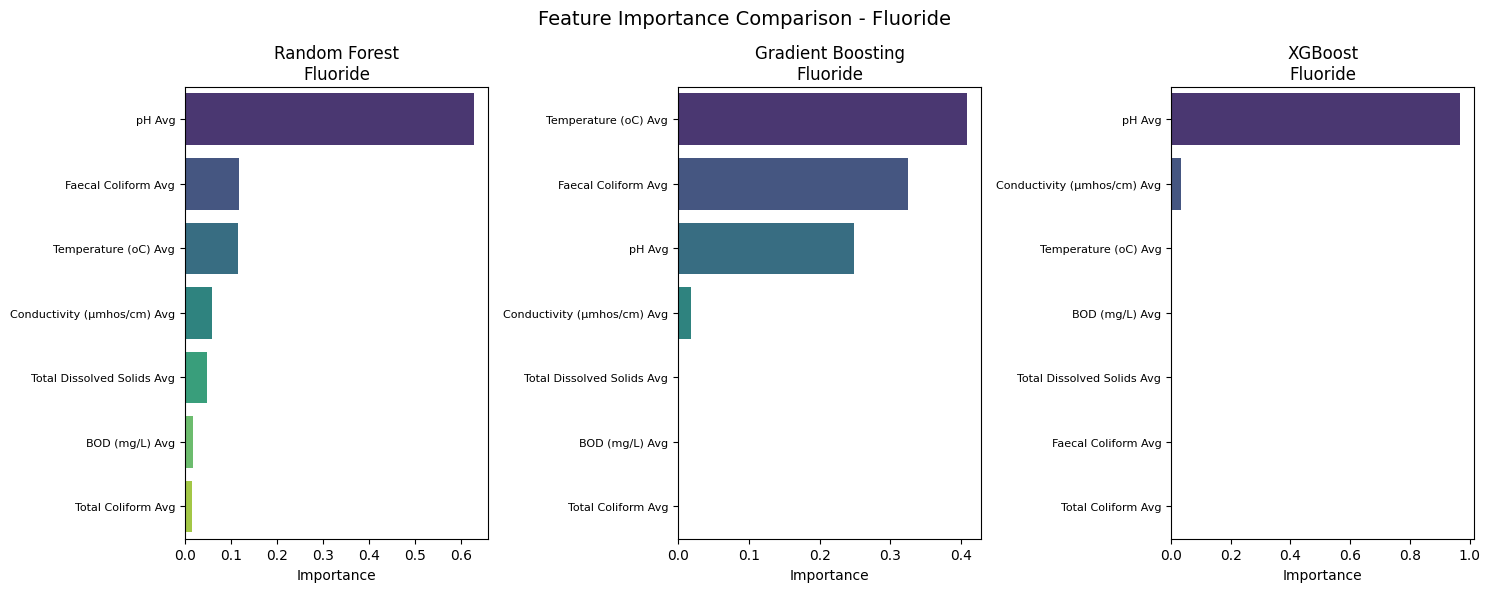

/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')
/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')
/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')


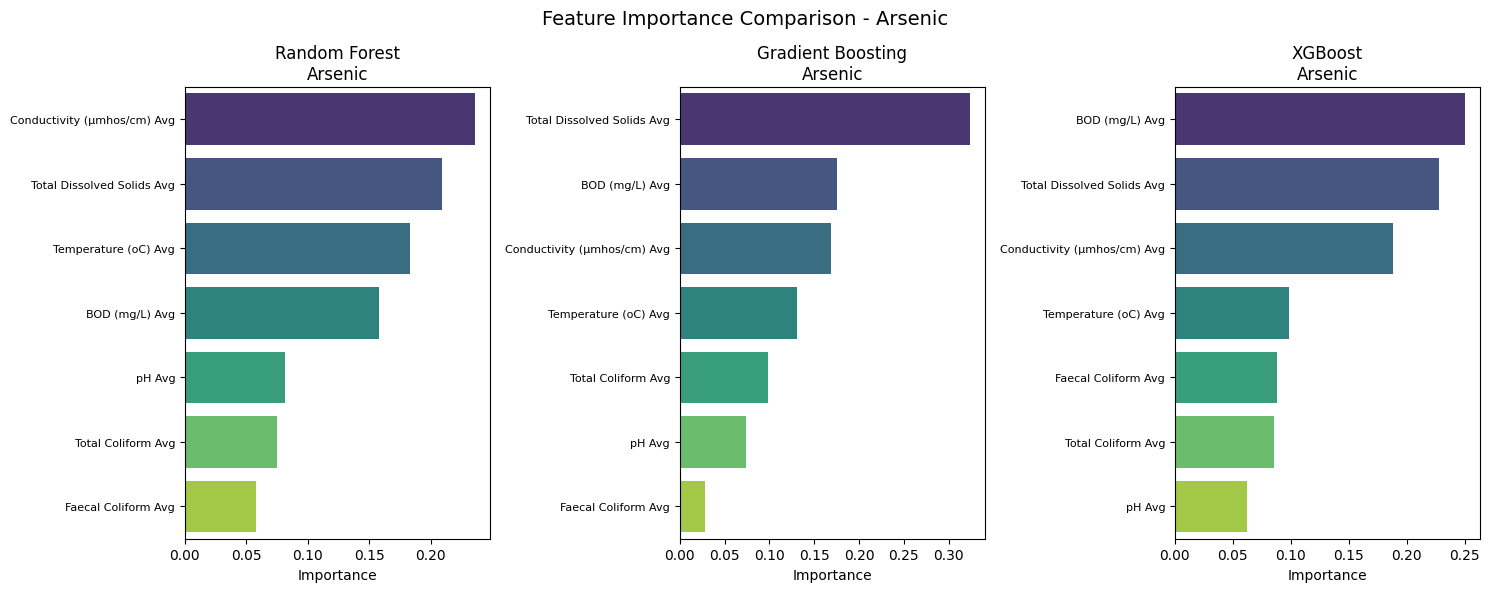

/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')
/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')
/tmp/ipython-input-32-3223532912.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, ax=ax, palette='viridis')


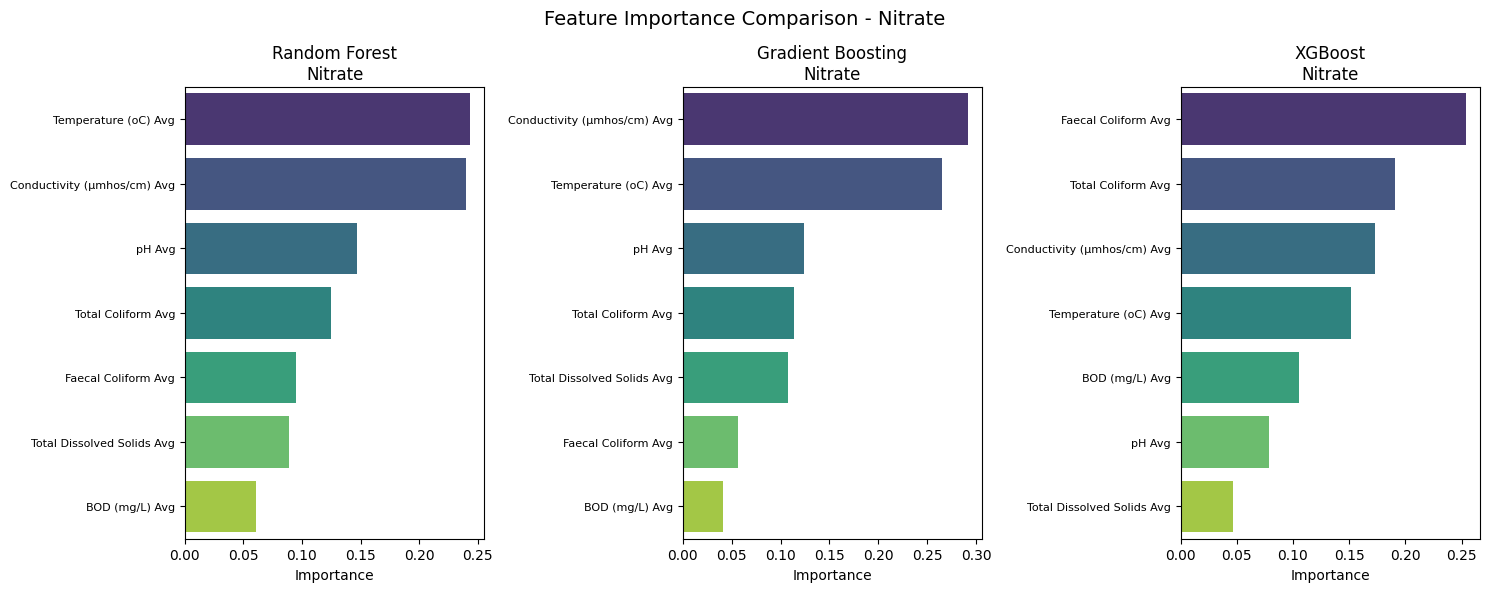

In [33]:
for target_name in results:
    importances_dict = {}
    for model_name, metrics in results[target_name].items():
        if metrics['feature_importances'] is not None:
            importances_dict[model_name] = metrics['feature_importances']

    if importances_dict:
        plot_horizontal_feature_importance(importances_dict, target_name, features)